In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
Dtrain = pd.read_csv("../TrainingSet (IR - 21).csv")
#Dtrain = Dtrain.iloc[:,0:4].values
Dtest = pd.read_csv("../TestingSet (IR - 21).csv")

In [3]:
print(Dtrain.shape)
print(Dtest.shape)

(193792, 4)
(48448, 4)


In [4]:
Dtrain["Bearing"].value_counts()

Inner Race (0.021")    96896
Normal                 96896
Name: Bearing, dtype: int64

In [5]:
Dtrain["Bearing"].value_counts(normalize=True)*100

Inner Race (0.021")    50.0
Normal                 50.0
Name: Bearing, dtype: float64

In [6]:
Dtest.columns

Index(['Bearing', 'Fault Diameter', 'DE', 'FE'], dtype='object')

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtrain["Bearing"] = labelencoder_train.fit_transform(Dtrain["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtrain = ct.fit_transform(Dtrain)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtest["Bearing"] = labelencoder_train.fit_transform(Dtest["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtest = ct.fit_transform(Dtest)

print(Dtest)

[[ 0.          1.          0.         -0.04965046 -0.09635818]
 [ 0.          1.          0.         -0.00438092 -0.11957455]
 [ 0.          1.          0.         -0.00333785 -0.11258909]
 ...
 [ 1.          0.          0.021       0.19451607 -0.00801273]
 [ 1.          0.          0.021       0.29969281  0.05300727]
 [ 1.          0.          0.021      -0.18030299 -0.09902909]]


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(Dtrain))
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(Dtest))

In [10]:
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers

Using TensorFlow backend.


In [11]:
import tensorflow as tf
from numpy.random import seed
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

In [12]:
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(32, activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2, activation=act_func, kernel_initializer='glorot_uniform'))

model.add(Dense(32, activation=act_func, kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1], kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


In [13]:
NUM_EPOCHS=100
BATCH_SIZE=1000
history=model.fit(X_train,X_train, 
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1,
                  shuffle = False)

Train on 174412 samples, validate on 19380 samples
Epoch 1/100
174412/174412 [==============================] - 1s 3us/step - loss: 0.1188 - val_loss: 0.0032
Epoch 2/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0207 - val_loss: 0.0026
Epoch 3/100
174412/174412 [==============================] - 0s 3us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 5/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 9/100
174412/174412 [==============================] - 0s 2us/step - loss: 0.0012 - val

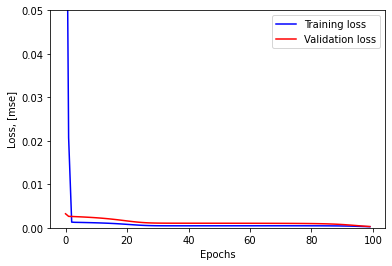

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.05])
plt.show()

In [15]:
X_pred = model.predict(X_train)

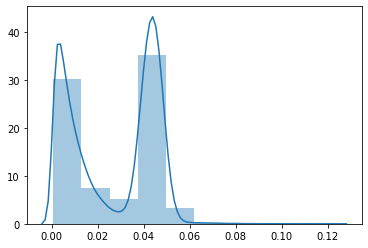

In [16]:
import seaborn as sns

scored = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
g = sns.distplot(scored, bins = 10, kde= True);
#g.set(xlim=(0.05,0.10), ylim=(0, 1))
plt.show()

In [17]:
model.evaluate(X_test,X_test)

48448/48448 [==============================] - 1s 14us/step


0.0011990746171698205

In [18]:
TH = 0.07
scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
scored['Threshold'] = TH
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.sample(100)

,Loss_mae,Threshold,Anomaly
188418,0.001954,0.07,False
101783,0.009817,0.07,False
6365,0.048580,0.07,False
125498,0.036889,0.07,False
151197,0.054696,0.07,False
...,...,...,...
165726,0.001742,0.07,False
23551,0.044246,0.07,False
36681,0.042019,0.07,False
124383,0.001941,0.07,False


In [19]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = TH
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [20]:
scored_train['Loss_mae'].mean()

0.02687285281294006

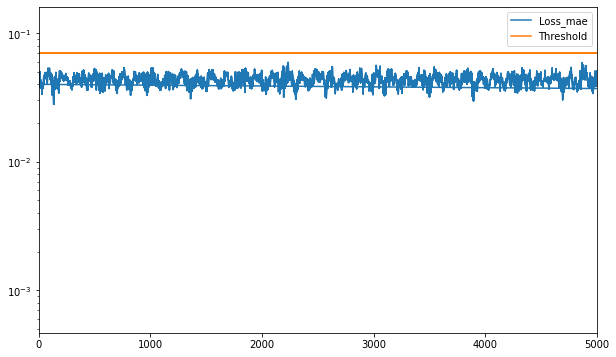

In [21]:
scored.plot(logy=True,  figsize = (10,6), xlim =[0,5000])

In [22]:
scored_train

,Loss_mae,Threshold,Anomaly
0,0.039978,0.07,False
1,0.037739,0.07,False
2,0.040839,0.07,False
3,0.042227,0.07,False
4,0.043573,0.07,False
...,...,...,...
193787,0.003602,0.07,False
193788,0.000864,0.07,False
193789,0.002672,0.07,False
193790,0.001107,0.07,False


In [23]:
anomalies = scored_train[scored_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Loss_mae  Threshold  Anomaly
96974   0.080578       0.07     True
96978   0.074834       0.07     True
97132   0.071494       0.07     True
98190   0.072431       0.07     True
98198   0.074440       0.07     True
...          ...        ...      ...
191953  0.070212       0.07     True
192334  0.075670       0.07     True
192338  0.077214       0.07     True
193170  0.103953       0.07     True
193174  0.091568       0.07     True

[306 rows x 3 columns]
(306, 3)


In [24]:
NB_anomalies = anomalies[anomalies.index <= 96896]
print(NB_anomalies)
print(NB_anomalies.shape)

Empty DataFrame
Columns: [Loss_mae, Threshold, Anomaly]
Index: []
(0, 3)


In [25]:
IR21_anomalies = anomalies[anomalies.index > 96896]
print(IR21_anomalies)
print(IR21_anomalies.shape)

        Loss_mae  Threshold  Anomaly
96974   0.080578       0.07     True
96978   0.074834       0.07     True
97132   0.071494       0.07     True
98190   0.072431       0.07     True
98198   0.074440       0.07     True
...          ...        ...      ...
191953  0.070212       0.07     True
192334  0.075670       0.07     True
192338  0.077214       0.07     True
193170  0.103953       0.07     True
193174  0.091568       0.07     True

[306 rows x 3 columns]
(306, 3)


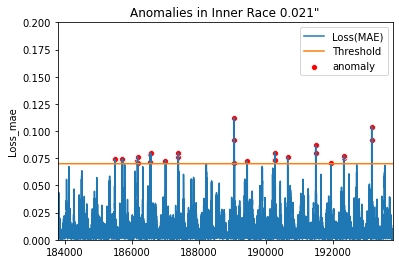

In [27]:
plt.plot(scored_train.index, scored_train.Loss_mae, label='Loss(MAE)');
plt.plot(scored_train.index, scored_train.Threshold, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (len(scored_train.index)-10000, len(scored_train.index)), ylim = (0, 0.2))
plt.title('Anomalies in Inner Race 0.021"')
plt.legend();